In [29]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline
from webcolors import rgb_to_name
import imageio

(-0.5, 1942.5, 1542.5, -0.5)

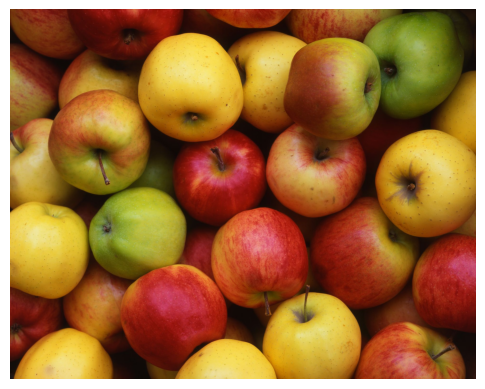

In [30]:
image = cv2.imread(r'classify.jpg', cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 1942.5, 1542.5, -0.5)

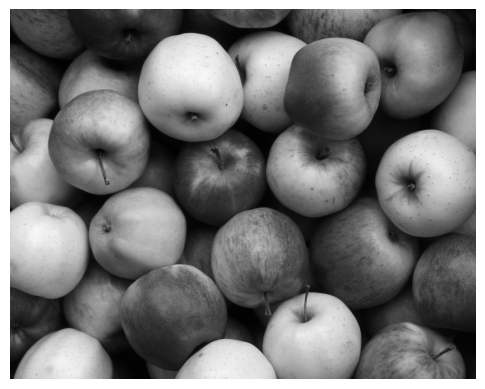

In [31]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = "gray")
plt.axis('off')

True

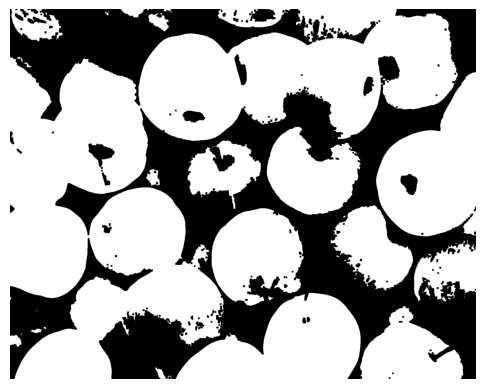

In [32]:
_ , mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
mask = cv2.erode(mask, np.ones((7, 7), np.uint8))
plt.imshow(mask, cmap = "gray")
plt.axis('off')
cv2.imwrite('thresholding.png', cv2.hconcat([image, np.stack((mask, mask, mask), axis=2)]))

(-0.5, 1942.5, 1542.5, -0.5)

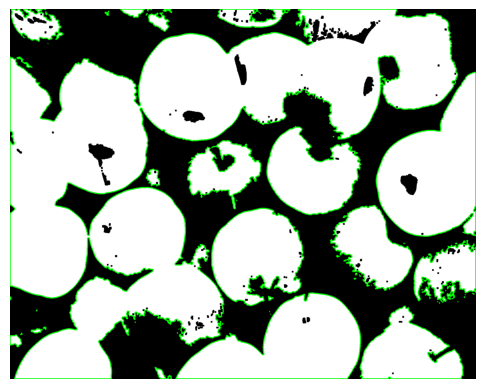

In [33]:
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_img_before_filtering = mask.copy()
contours_img_before_filtering = cv2.cvtColor(contours_img_before_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_before_filtering, contours, -1, (0, 255, 0), 3)
plt.imshow(contours_img_before_filtering)
plt.axis('off')

In [34]:
filtered_contours = []
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    area = int(cv2.contourArea(contour))

    if area > 3000:
        filtered_contours.append(contour)
        # get mean color of contour:
        masked = np.zeros_like(image[:, :, 0]) 
        cv2.drawContours(masked, [contour], 0, 255, -1)

        B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
        df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
        df_mean_color = pd.concat([df_mean_color, df])

df_mean_color.head()

,B_mean,G_mean,R_mean
14,40.276944,83.044062,173.017227
29,58.964742,177.881813,215.786277
51,44.796293,49.346300,172.858954
53,46.657167,74.954318,195.714759
54,34.667376,82.037555,165.504421


True

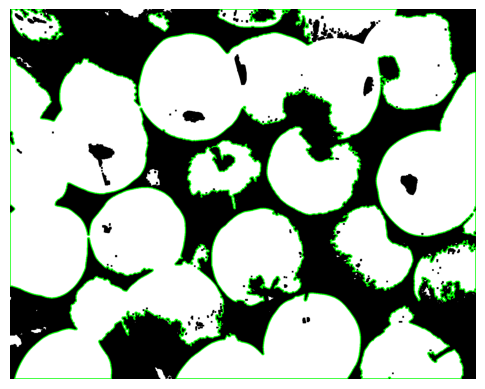

In [35]:
contours_img_after_filtering = mask.copy()
contours_img_after_filtering = cv2.cvtColor(contours_img_after_filtering, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contours_img_after_filtering, tuple(filtered_contours), -1, (0, 255, 0), 3)

plt.imshow(contours_img_after_filtering)
plt.axis('off')

cv2.imwrite('contours.png', cv2.hconcat([contours_img_before_filtering, contours_img_after_filtering]))

In [36]:
km = KMeans( n_clusters=6)
df_mean_color['label'] = km.fit_predict(df_mean_color)

/Users/yosepwijaya/opt/anaconda3/envs/countcolor/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [37]:
def draw_segmented_objects(image, contours, label_cnt_idx, bubbles_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{bubbles_count} apples', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
    fontScale = 3, color = (255, 255, 255), thickness = 10, lineType = cv2.LINE_AA)
    return masked_image

In [38]:
color_list = [
    ['red', [0, 160, 70], [10, 250, 250]],
    ['pink', [0, 50, 70], [10, 160, 250]],
    ['yellow', [15, 50, 70], [30, 250, 250]],
    ['green', [40, 50, 70], [70, 250, 250]],
    ['cyan', [80, 50, 70], [90, 250, 250]],
    ['blue', [100, 50, 70], [130, 250, 250]],
    ['purple', [140, 50, 70], [160, 250, 250]],
    ['red', [170, 160, 70], [180, 250, 250]],
    ['pink', [170, 50, 70], [180, 160, 250]]
]

In [39]:
def detect_main_color(hsv_image, colors):
    color_found = 'undefined'
    max_count = 0

    for color_name, lower_val, upper_val in colors:
        mask = cv2.inRange(hsv_image, np.array(lower_val), np.array(upper_val))

        count = np.sum(mask)
        if count > max_count:
            color_found = color_name
            max_count = count

    return color_found

3: yellow
3: red
2: red
2: red
1: yellow
1: red
       B_mean     G_mean      R_mean
92  18.062678  52.511218  124.782267


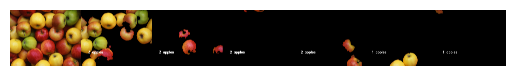

In [40]:
img = image.copy()
from webcolors import rgb_to_name
for label, df_grouped in df_mean_color.groupby('label'):
    apples_amount = len(df_grouped)
    named_color = rgb_to_name((255,0,0), spec='css3')
    df_grouped.drop('label', inplace=True, axis=1)
    
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, apples_amount)
    
    hsv = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)
    
    print(f"{apples_amount}: {detect_main_color(hsv, color_list)}")
    
    cv2.imwrite(f'apple_colored_{detect_main_color(hsv, color_list)}{label}.jpg', masked_image)
    
    img = cv2.hconcat([img, masked_image])
    

cv2.imwrite('color_segmentation.png', img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off')

print(df_grouped.head())